In [1]:
import argparse
import os
import math
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path

from IPython.display import display

# ------------


def set_matplotlib_style():
    mpl.rcParams.update({
        # Fonts
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
        "mathtext.fontset": "stix",
        "axes.unicode_minus": False,

        # Text sizes (pt)
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "legend.fontsize": 8,

        # Lines/markers
        "axes.linewidth": 0.8,
        "lines.linewidth": 1.2,

        # Save as vector-friendly
        "pdf.fonttype": 42,  # TrueType in PDF
        "ps.fonttype": 42,

        # Layout / figure
        "figure.dpi": 150,
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.0,
    })

set_matplotlib_style()

In [2]:

# IEEE-ish sizes
SINGLE_COL_W = 3.39  # inches (IEEE single column)
DOUBLE_COL_W = 7.16  # inches (IEEE double column)



In [11]:
def _finalize_axes(ax, title=None, xlabel=None, ylabel=None, legend=False):
    if title:
        ax.set_title(title, pad=4)
    if xlabel:
        ax.set_xlabel(xlabel, labelpad=2)
    if ylabel:
        ax.set_ylabel(ylabel, labelpad=2)

    # Clean spines
    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    # Light y-grid
    ax.grid(axis="y", alpha=0.25, linewidth=0.6)
    if legend:
        leg = ax.legend(frameon=False, handlelength=1.5, borderpad=0.2, loc="best")
        for lh in getattr(leg, "legendHandles", []):
            lh.set_linewidth(1.0)

def _save_and_show(fig, outpath_pdf: str, show=True):
    Path(outpath_pdf).parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(outpath_pdf, format="pdf", bbox_inches="tight", pad_inches=0)
    if show:
        display(fig)
    plt.close(fig)

# --- Your existing helpers kept as-is (hours, latex) ---
def _safe_hours(x):
    try:
        return float(x) / 3600.0
    except Exception:
        return 0.0

def _fmt_hours(h):
    return f"{h:,.2f}"

def _fmt_pct(p):
    return f"{p*100:.1f}\\%"

def _clean_df(df, valid_only=True):
    if 'language' in df.columns:
        df['language'] = df['language'].fillna('Unknown')
    else:
        df['language'] = 'Unknown'
    if 'dataset_type' in df.columns:
        df['dataset_type'] = df['dataset_type'].fillna('Unknown')
    else:
        df['dataset_type'] = 'Unknown'

    df['duration'] = pd.to_numeric(df['duration'], errors='coerce').fillna(0.0)
    df = df[df['duration'] > 0]

    if valid_only and 'is_valid' in df.columns:
        df = df[df['is_valid'] == True]

    df['language'] = df['language'].apply(lambda x: x if x in ['FR', 'DE'] else 'Other')
    return df

def _hours_by(group_df, by_cols):
    agg = (group_df
           .groupby(by_cols, dropna=False)['duration']
           .sum()
           .reset_index())
    agg['hours'] = agg['duration'].apply(_safe_hours)
    return agg

def _latex_overview_table(df, outpath_tex, caption="Corpus overview by language", label="tab:dataset_overview"):
    rows = []
    for name, filt in [("Total", df.index), ("French (FR)", df['language']=="FR"), ("German (DE)", df['language']=="DE")]:
        sub = df.loc[filt]
        hours = _safe_hours(sub['duration'].sum())
        files = len(sub)
        avg_sec = sub['duration'].mean() if files > 0 else 0
        med_sec = sub['duration'].median() if files > 0 else 0
        avg_word_count = sub['word_count'].mean() if files > 0 else 0
        libri_sec = sub.loc[sub['dataset_type']=="LibriSpeech", 'duration'].sum()
        emonet_sec = sub.loc[sub['dataset_type']=="EmoNet", 'duration'].sum()
        total_sec = sub['duration'].sum()
        libri_ratio = (libri_sec / total_sec) if total_sec > 0 else 0
        emonet_ratio = (emonet_sec / total_sec) if total_sec > 0 else 0
        rows.append({
            "name": name,
            "hours": hours,
            "files": files,
            "avg": avg_sec,
            "avg_word": avg_word_count,
            "libri_pct": libri_ratio,
            "emonet_pct": emonet_ratio
        })

        # file_path,duration,split,language,dataset_type,voice,char_count,word_count,file_size_wav,is_valid

    lines = []
    lines.append("\\begin{table}[htbp]")
    lines.append("\\centering")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append("\\begin{tabular}{lrrrrr}")
    lines.append("\\toprule")
    lines.append(" & Hours & Files & Avg dur (s) & Avg word count & Libri/Emo \\\\")
    lines.append("\\midrule")
    for r in rows:
        lines.append(
            f"{r['name']} & "
            f"{_fmt_hours(r['hours'])} & "
            f"{r['files']:,} & "
            f"{r['avg']:.2f} & "
            f"{r['avg_word']:.2f} & "
            f"{_fmt_pct(r['libri_pct'])}/{_fmt_pct(r['emonet_pct'])} \\\\"
        )
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("\\end{table}")

    Path(outpath_tex).parent.mkdir(parents=True, exist_ok=True)
    with open(outpath_tex, "w", encoding="utf-8") as f:
        f.write("\n".join(lines))
    print(f"[LaTeX] wrote {outpath_tex}")

# --- Polished figures (PDF + inline display) ---
def plot_hours_by_language(df, outpdf, show=True, width=SINGLE_COL_W, height=2.2):
    hours = _hours_by(df, ['language'])
    order = ['FR', 'DE']
    hours = hours[hours['language'].isin(order)]
    hours = hours.set_index('language').reindex(order).reset_index()

    fig, ax = plt.subplots(figsize=(width, height))
    bars = ax.bar(hours['language'], hours['hours'])

    # Labels on bars
    for rect, h in zip(bars, hours['hours']):
        ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(),
                f"{h:.0f}h", ha='center', va='bottom', fontsize=8)

    _finalize_axes(ax,
        # title="Total Hours by Language",
        xlabel="Language",
        ylabel="Hours",
        legend=False
    )
    _save_and_show(fig, outpdf, show=show)

def plot_stacked_hours_by_language_dataset(df, outpdf, show=True, width=3.9, height=2.3):
    # Slightly wider than single column to fit legend comfortably
    g = _hours_by(df, ['language','dataset_type'])
    langs = ['FR','DE']
    datasets = ['LibriSpeech','EmoNet']

    pv = g.pivot_table(index='language', columns='dataset_type', values='hours', fill_value=0.0)
    pv = pv.reindex(index=[x for x in langs if x in pv.index], columns=[x for x in datasets if x in pv.columns])

    fig, ax = plt.subplots(figsize=(width, height))
    bottom = np.zeros(len(pv.index))
    for col in pv.columns:
        vals = pv[col].values
        ax.bar(pv.index, vals, bottom=bottom, label=col)
        bottom += vals

    _finalize_axes(ax,
        # title="Hours by Language and Dataset",
        xlabel="Language",
        ylabel="Hours",
        legend=True
    )
    _save_and_show(fig, outpdf, show=show)


def plot_stacked_hours_abs_with_pct(
    df, outpdf, show=True, width=3.9, height=2.3, bar_width=0.5
):
    """
    Stacked bars of absolute hours (LibriSpeech+EmoNet) per language.
    Annotates each segment with its share (%) of the language total.
    Colors match histogram defaults; slimmer bars; legend above.
    """
    import matplotlib.patheffects as pe

    langs = ['FR', 'DE']
    datasets = ['LibriSpeech', 'EmoNet']
    colors = {'LibriSpeech': 'C0', 'EmoNet': 'C1'}

    # hours aggregation
    g = (df.groupby(['language','dataset_type'])['duration'].sum().reset_index())
    g = g[g['language'].isin(langs)]
    pv = g.pivot_table(index='language', columns='dataset_type', values='duration', fill_value=0.0)
    pv = pv.reindex(index=[x for x in langs if x in pv.index], columns=[d for d in datasets if d in pv.columns])

    hours = (pv / 3600.0)  # convert to hours for bar heights
    totals_h = hours.sum(axis=1)

    fig, ax = plt.subplots(figsize=(width, height))
    x = np.arange(len(hours.index))
    bottom = np.zeros(len(hours.index))

    handles = []
    labels = []
    for col in hours.columns:
        vals = hours[col].values
        h = ax.bar(x, vals, bottom=bottom, width=bar_width, label=col, color=colors.get(col, None), alpha=1, linewidth=0.1)
        handles.append(h)
        labels.append(col)

        # annotate percentages inside each segment
        for i, v in enumerate(vals):
            if v <= 0: 
                continue
            share = (v / totals_h.iloc[i]) if totals_h.iloc[i] > 0 else 0.0
            if share > 0.06:  # annotate only if big enough to read
                y_center = bottom[i] + v/2
                ax.text(
                    x[i], y_center, f"{share*100:.0f}%",
                    ha='center', va='center', fontsize=8,
                    color='black',
                    # path_effects=[pe.withStroke(linewidth=1.2, foreground='black')]
                )
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(hours.index)

    # Numeric hour labels above bars (compact)
    for i, total in enumerate(totals_h.values):
        ax.text(x[i], total, f"{total:.0f}h", ha='center', va='bottom', fontsize=8)

    # Legend above, outside (prevents overlap)
    ax.legend(
        handles=[h[0] for h in handles],
        labels=labels,
        frameon=False,
        loc="upper left",
        ncol=1
    )
    _finalize_axes(ax, xlabel="Language", ylabel="Hours", legend=False)
    _save_and_show(fig, outpdf, show=show)



def plot_composition_100_stacked_by_language_dataset(
    df, outpdf, show=True, width=3.39, height=2.0, bar_width=0.5
):
    """
    100% stacked bars (LibriSpeech vs EmoNet) per language (FR/DE).
    More compact than raw-hour bars; emphasizes composition, not absolute size.
    """
    langs = ['FR', 'DE']
    datasets = ['LibriSpeech', 'EmoNet']

    g = (df.groupby(['language','dataset_type'])['duration'].sum().reset_index())
    g = g[g['language'].isin(langs)]
    # pivot to seconds
    pv = g.pivot_table(index='language', columns='dataset_type', values='duration', fill_value=0.0)
    # keep only known datasets; handle missing columns
    pv = pv.reindex(index=[x for x in langs if x in pv.index], columns=[d for d in datasets if d in pv.columns])

    # normalize to 100%
    totals = pv.sum(axis=1).replace(0, 1.0)
    comp = (pv.T / totals).T  # fractions

    fig, ax = plt.subplots(figsize=(width, height))

    x = np.arange(len(comp.index))
    bottom = np.zeros(len(comp.index))
    for col in comp.columns:
        vals = comp[col].values
        ax.bar(x, vals, bottom=bottom, width=bar_width, label=col)
        bottom += vals

    ax.set_xticks(x)
    ax.set_xticklabels(comp.index)
    ax.set_ylim(0, 1.0)

    # add percent labels
    for i, lang in enumerate(comp.index):
        start = 0.0
        for col in comp.columns:
            v = comp.loc[lang, col]
            if v > 0.05:  # only annotate sizable slices
                ax.text(i, start + v/2, f"{v*100:.0f}%", ha='center', va='center', fontsize=8)
            start += v

    _finalize_axes(ax,
        xlabel="Language",
        ylabel="Share",
        legend=True
    )
    _save_and_show(fig, outpdf, show=show)


def plot_duration_hist_overall(df, outpdf, show=True, max_sec=60, bins=48, width=SINGLE_COL_W, height=2.2):
    dd = df['duration'].clip(upper=max_sec)
    fig, ax = plt.subplots(figsize=(width, height))
    ax.hist(dd, bins=bins)

    _finalize_axes(ax,
        # title=f"Clip Duration Distribution (0–{max_sec}s)",
        xlabel="Clip length (s)",
        ylabel="Count",
        legend=False
    )
    _save_and_show(fig, outpdf, show=show)

def plot_duration_hist_by_dataset(df, outpdf, show=True, max_sec=60, bins=48, width=3.9, height=2.3):
    fig, ax = plt.subplots(figsize=(width, height))
    # Ensure order: LibriSpeech (blue), EmoNet (orange)
    dataset_order = ['LibriSpeech', 'EmoNet']
    colors = {'LibriSpeech': 'C0', 'EmoNet': 'C1'}
    for ds_name in dataset_order:
        if ds_name in df['dataset_type'].unique():
            sub = df[df['dataset_type'] == ds_name]
            dd = sub['duration'].clip(upper=max_sec)
            ax.hist(
                dd, bins=bins, alpha=1, label=ds_name, color=colors[ds_name],
                edgecolor='black', linewidth=0.1
            )

    _finalize_axes(ax,
        # title=f"Clip Duration by Dataset (0–{max_sec}s)",
        xlabel="Clip length (s)",
        ylabel="Count",
        legend=True
    )
    _save_and_show(fig, outpdf, show=show)

def plot_top_speakers(df, outpdf, top_n=15, show=True, width=4.2, height=None):
    if 'voice' not in df.columns:
        return
    agg = _hours_by(df, ['voice']).sort_values('hours', ascending=False).head(top_n)
    if height is None:
        height = max(2.2, 0.28*len(agg))  # compact

    fig, ax = plt.subplots(figsize=(width, height))
    ax.barh(agg['voice'], agg['hours'])
    ax.invert_yaxis()
    for i, h in enumerate(agg['hours']):
        ax.text(h, i, f" {h:.1f}h", va='center', ha='left', fontsize=8)

    _finalize_axes(ax,
        title=f"Top {len(agg)} Speakers by Duration",
        xlabel="Hours",
        ylabel=None,
        legend=False
    )
    _save_and_show(fig, outpdf, show=show)

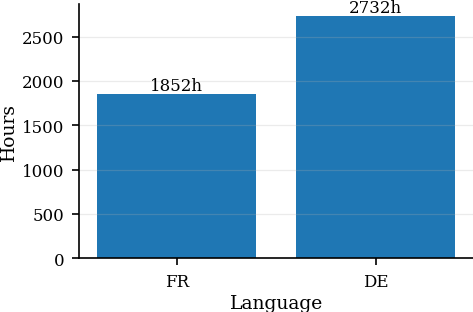

/tmp/ipykernel_1416574/910882137.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in getattr(leg, "legendHandles", []):


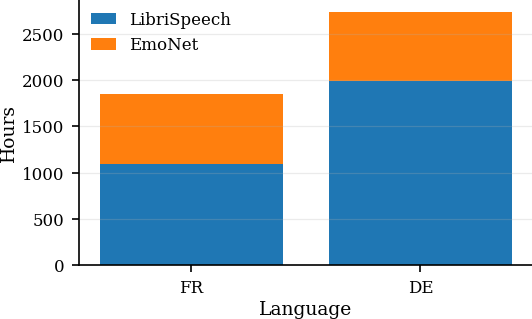

/tmp/ipykernel_1416574/910882137.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in getattr(leg, "legendHandles", []):


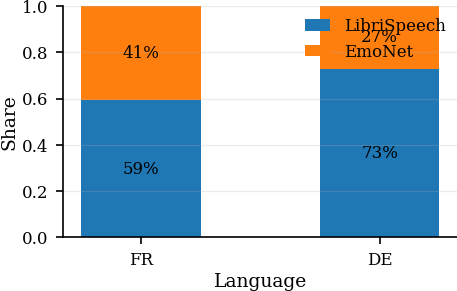

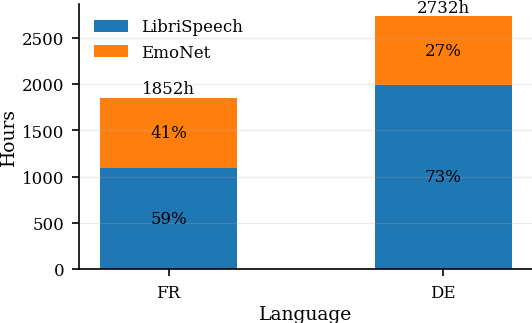

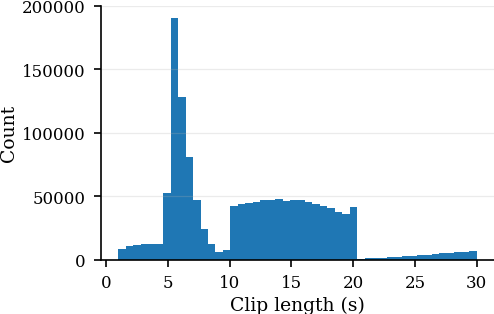

/tmp/ipykernel_1416574/910882137.py:17: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for lh in getattr(leg, "legendHandles", []):


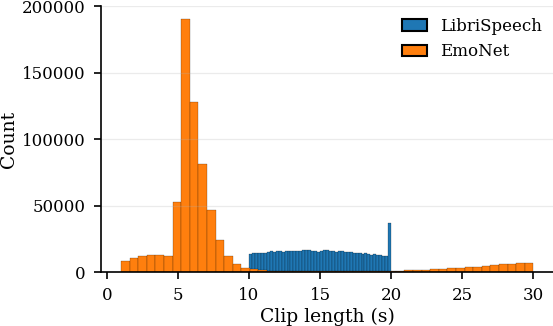

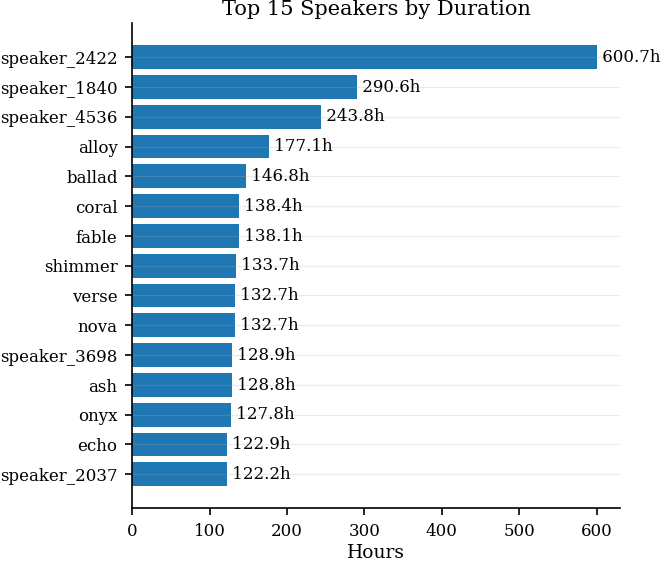

[LaTeX] wrote plots/dataset_overview.tex


In [12]:
out_dir = "plots"
mapper_csv = "/tsi/hi-paris/tts/Luka/data/audio_duration_mapping.csv"
valid_only = True
appendix_plots = True

Path(out_dir).mkdir(parents=True, exist_ok=True)

df = pd.read_csv(mapper_csv)
df = _clean_df(df, valid_only=valid_only)

# Main figures (PDF + inline display)
plot_hours_by_language(
    df, outpdf=str(Path(out_dir, "hours_by_language.pdf")), show=True
)
plot_stacked_hours_by_language_dataset(
    df, outpdf=str(Path(out_dir, "stacked_hours_by_language_dataset.pdf")), show=True
)

plot_composition_100_stacked_by_language_dataset(
    df, outpdf=str(Path(out_dir, "composition_100_stacked_by_language_dataset.pdf")), show=True
)


plot_stacked_hours_abs_with_pct(
    df, outpdf=str(Path(out_dir, "stacked_hours_abs_with_pct.pdf")), show=True
)

plot_duration_hist_overall(
    df, outpdf=str(Path(out_dir, "hist_duration_overall.pdf")), show=True
)

# Appendix (optional)
if appendix_plots:
    plot_duration_hist_by_dataset(
        df, outpdf=str(Path(out_dir, "hist_duration_by_dataset.pdf")), show=True
    )
    plot_top_speakers(
        df, outpdf=str(Path(out_dir, "top_speakers_by_duration.pdf")), show=True
    )

# LaTeX table
_latex_overview_table(
    df,
    outpath_tex=str(Path(out_dir, "dataset_overview.tex")),
    caption="Corpus overview (Total, French, German) with dataset composition.",
    label="tab:dataset_overview"
)